In [1]:
from maskgit_lowres_trainer import ImageTextDataset
from math import sqrt
from random import choice
from pathlib import Path
from shutil import rmtree
from functools import partial

from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image

from vae import VQGanVAE

from einops import rearrange

from accelerate import Accelerator

from ema import EMA

import json
from tqdm import tqdm, trange

from transformers import Adafactor

import matplotlib.pyplot as plt


/home/ubuntu/anaconda3/envs/muse/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [32]:
image = T.Resize((1024, 1024))(T.ToTensor()(T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img)(Image.open("5.jpg"))))

In [33]:
vae = VQGanVAE(
    dim = 128,
    codebook_size = 8192
)

vae.load("results-backup/vae.400000.ema.pt", is_ema=True)

In [34]:
enc, indices, loss = vae.encode(image.unsqueeze(0))

In [45]:
indices = torch.load("../COCO-Captions/train_tokens/000000000025.pt")

In [46]:
indices.shape

torch.Size([16, 16])

In [50]:
class ImageTextDataset(Dataset):
  def __init__(
      self,
      folder,
      token_folder,
      annotations_path,
      image_size,
      tokenizer = None,
      exts = ['jpg', 'jpeg', 'png']
  ):
    super().__init__()
    self.image_size = image_size
    self.tokenizer = tokenizer
    self.token_folder = Path(token_folder)

    if yes_or_no("Do you want to clear token folder and recompute tokens? (yes/no)"):
      rmtree(str(self.token_folder))
      self.token_folder.mkdir(parents = True, exist_ok = True)
      self.should_compute_tokens = True
    else:
      self.should_compute_tokens = False
      
    
    self.transform = T.Compose([
      T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
      T.Resize((image_size, image_size)),
      # image might not fit the text after flip and crop
      # T.RandomHorizontalFlip(),
      # T.CenterCrop(image_size),
      T.ToTensor()
    ])

    image_paths = [p for ext in exts for p in Path(f'{folder}').glob(f'**/*.{ext}')]

    image_annotations = json.load(open(annotations_path))["annotations"]

    image_annotations_keyed = dict()
    for annotation in image_annotations:
      image_id = annotation["image_id"]
      caption = annotation["caption"]
      if image_id not in image_annotations_keyed:
        image_annotations_keyed[image_id] = []
      image_annotations_keyed[image_id].append(caption)

    self.data = []
    for path in tqdm(image_paths):
      image_id = path.name.split(".")[0]
      encoded_path = f'{token_folder}/{image_id}.pt'
      for text in image_annotations_keyed[int(image_id)]:
        image_data = {
          "path": path,
          "encoded_path": encoded_path,
          "texts": text,
        }
        self.data.append(image_data)

      if self.should_compute_tokens:
          with torch.no_grad():
              tokens, indices, loss = self.tokenizer.encode(self.transform(Image.open(path)).unsqueeze(0).cuda())
              torch.save(indices[0], encoded_path)

    print(f'Found {len(self.data)} training samples at {folder}')

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    path = self.data[index]["path"]
    texts = self.data[index]["texts"]
    encoded_img = torch.load(self.data[index]["encoded_path"])
    img = Image.open(path)
    return encoded_img, self.transform(img), texts
  

In [54]:
def yes_or_no(question):
  answer = input(f'{question} (y/n)')
  return answer.lower() in ['yes', 'y']

In [55]:
image_folder = "../COCO-Captions/train2017"
token_folder = "../COCO-Captions/train_tokens"
caption_file = "../COCO-Captions/annotations_trainval2017/captions_train2017.json"

In [56]:
ds = ImageTextDataset(image_folder, token_folder, caption_file, 256, tokenizer = None)

100%|██████████| 118287/118287 [00:01<00:00, 93334.76it/s]


Found 591753 training samples at ../COCO-Captions/train2017


In [57]:
dl = DataLoader(
  ds,
  batch_size = 4,
  shuffle = True,
  drop_last = True
)

In [58]:
for data in dl:
  break

In [64]:
indices, encoded, texts = data

In [65]:
indices

tensor([[[7551, 5642, 3594,  ..., 4043, 4143, 1952],
         [1398, 4032, 2711,  ..., 2751,  320, 1844],
         [2258, 5087, 6509,  ..., 5118, 5443, 4661],
         ...,
         [1685, 5626,  231,  ...,  570, 1031, 7988],
         [4532, 7323, 2845,  ..., 6079, 4884, 3632],
         [1521, 7621, 6868,  ..., 2636,  976, 8181]],

        [[2895,  661, 5960,  ...,  543, 5918, 4779],
         [6372, 4657, 1064,  ..., 5747, 1818, 7101],
         [6218, 8116, 4221,  ..., 7398,  147, 2020],
         ...,
         [5547, 5293, 2220,  ...,  516,  193, 7780],
         [3883, 5159, 4608,  ..., 3731, 5037,   48],
         [1198, 7658, 7883,  ...,   31, 6892,  433]],

        [[6604,  657, 7236,  ..., 1035, 5965, 1137],
         [7416, 2487, 4158,  ..., 6421, 5904, 2339],
         [7177, 6958, 7835,  ..., 1298,  457,  164],
         ...,
         [7294, 1859, 5550,  ..., 2809, 2140, 5554],
         [2546, 7823, 2570,  ..., 3055,  337, 7476],
         [6451,  774, 5266,  ..., 1567,  340, 7412]],

In [66]:
indices.shape

torch.Size([4, 16, 16])

In [67]:
decoded = vae.decode_from_ids(indices.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


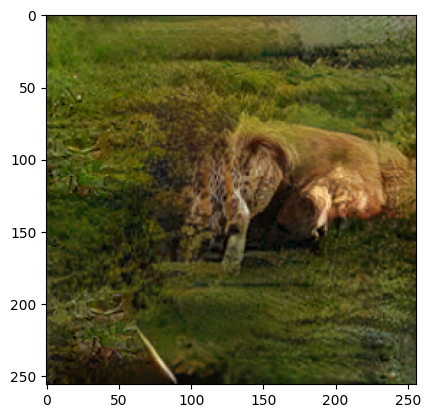

In [71]:
plt.imshow(decoded[3].permute(1, 2, 0).cpu().detach())

In [72]:
from vae import VQGanVAE
from trainers import VQGanVAETrainer

from maskgit_lowres_trainer import MaskGitTrainer
from masked_transformer import MaskGitTransformer, MaskGit, TokenCritic

train_path = "../COCO-Captions/train2017"
valid_path = "../COCO-Captions/val2017"

vae = VQGanVAE(
    dim = 128,
    codebook_size = 8192
)

vae.load("results-backup/vae.400000.ema.pt", is_ema=True)

transformer = MaskGitTransformer(
    num_tokens = 8192,       # must be same as codebook size above
    seq_len = 16*16,            # must be equivalent to fmap_size ** 2 in vae
    dim = 2048,                # model dimension
    depth = 24,                # depth
    dim_head = 64,            # attention head dimension
    heads = 8,                # attention heads,
    ff_mult = 2,              # feedforward expansion factor
)

base_maskgit = MaskGit(
    vae = vae,                 # vqgan vae
    transformer = transformer, # transformer
    image_size = 256,          # image size
    cond_drop_prob = 0.25,     # conditional dropout, for classifier free guidance
    self_token_critic = True,
    no_mask_token_prob = 0.25,
).cuda()

trainer = MaskGitTrainer(
    base_maskgit,
    image_folder = "../COCO-Captions/train2017",
    token_folder = "../COCO-Captions/train_tokens",
    caption_file = "../COCO-Captions/annotations_trainval2017/captions_train2017.json",
    num_train_steps = 300000,
    batch_size = 4,
    image_size = 256,
    lr = 1e-4,
    weight_decay = 0.045,
    grad_accum_every = 1,
    save_results_every = 100,
    save_model_every = 1000,
    results_folder = "./results-maskgit",
    random_split_seed = 42, 
    valid_frac = 0.05,
)

trainer.train()

/home/ubuntu/anaconda3/envs/muse/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


google/t5-v1_1-base
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


100%|██████████| 118287/118287 [00:01<00:00, 75391.99it/s] 


Found 591753 training samples at ../COCO-Captions/train2017
Split dataset into 562165 samples for training and 29588 samples for validating


KeyboardInterrupt: Interrupted by user

In [74]:
output = base_maskgit.generate(texts=["Text1", "Sentence", "Animal"])

  0%|          | 0/18 [00:00<?, ?it/s]

In [76]:
output.shape

torch.Size([3, 3, 256, 256])

In [77]:
output1, output2, output3 = base_maskgit.generate(texts=["Text1"]), base_maskgit.generate(texts=["Sentence"]), base_maskgit.generate(texts=["Animal"])

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [78]:
output1.shape

torch.Size([1, 3, 256, 256])

In [82]:
torch.norm(output[0] - output1)

tensor(98.7574, device='cuda:0')

In [83]:
torch.norm(output[1] - output2)

tensor(87.9136, device='cuda:0')

In [84]:
torch.norm(output[2] - output3)

tensor(105.3858, device='cuda:0')

In [79]:
output[0]

tensor([[[ 0.1676,  0.1030,  0.1131,  ...,  0.2867,  0.2302,  0.2186],
         [ 0.1002,  0.1066,  0.1242,  ...,  0.3899,  0.3654,  0.3443],
         [ 0.0832,  0.1097,  0.1087,  ...,  0.5946,  0.5337,  0.4506],
         ...,
         [ 0.5249,  0.5284,  0.4995,  ...,  0.6908,  0.6878,  0.6477],
         [ 0.5130,  0.5440,  0.5055,  ...,  0.7364,  0.7201,  0.6889],
         [ 0.4573,  0.5064,  0.5266,  ...,  0.7569,  0.7237,  0.6268]],

        [[ 0.2231,  0.1493,  0.1517,  ...,  0.1490,  0.1338,  0.1398],
         [ 0.1724,  0.1752,  0.1854,  ...,  0.1323,  0.1281,  0.1090],
         [ 0.1501,  0.1886,  0.1967,  ...,  0.3014,  0.2664,  0.1625],
         ...,
         [ 0.3147,  0.2915,  0.2612,  ...,  0.6488,  0.6433,  0.6240],
         [ 0.3333,  0.2961,  0.2860,  ...,  0.6977,  0.6942,  0.6541],
         [ 0.3290,  0.3091,  0.3211,  ...,  0.7234,  0.7106,  0.5973]],

        [[ 0.1752,  0.1205,  0.1365,  ..., -0.0149, -0.0347, -0.0046],
         [ 0.1458,  0.1214,  0.1273,  ...,  0

In [80]:
output1

tensor([[[[0.7882, 0.7333, 0.7852,  ..., 0.0452, 0.0234, 0.0591],
          [0.7300, 0.6905, 0.7058,  ..., 0.0538, 0.0621, 0.0957],
          [0.7195, 0.6801, 0.6825,  ..., 0.0335, 0.0583, 0.1025],
          ...,
          [0.7797, 0.7475, 0.5888,  ..., 0.1481, 0.1653, 0.1976],
          [0.7759, 0.7713, 0.6363,  ..., 0.1531, 0.1459, 0.1915],
          [0.5899, 0.6349, 0.6126,  ..., 0.1552, 0.1528, 0.1788]],

         [[0.7848, 0.7743, 0.7947,  ..., 0.0621, 0.0441, 0.0747],
          [0.7932, 0.7427, 0.7708,  ..., 0.0751, 0.0730, 0.1005],
          [0.7476, 0.7130, 0.7282,  ..., 0.0717, 0.0797, 0.1048],
          ...,
          [0.6343, 0.5750, 0.3449,  ..., 0.0462, 0.0371, 0.0293],
          [0.6108, 0.5637, 0.3594,  ..., 0.0282, 0.0092, 0.0259],
          [0.4752, 0.4582, 0.4086,  ..., 0.0352, 0.0276, 0.0799]],

         [[0.6931, 0.7543, 0.8475,  ..., 0.0417, 0.0170, 0.0400],
          [0.7716, 0.7946, 0.8348,  ..., 0.0549, 0.0621, 0.0790],
          [0.7778, 0.7641, 0.7604,  ..., 0